In [1]:
import dask_awkward as dak
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
from distributed import LocalCluster, Client, progress
import dask.dataframe as dd
import pandas as pd


client =  Client(n_workers=31,  threads_per_worker=1, processes=True, memory_limit='4 GiB') 

/depot/cms/kernels/coffea2024/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41147 instead
  warnings.warn(
2024-06-06 16:49:36,828 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:36661'.
2024-06-06 16:49:36,829 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:33891'.
2024-06-06 16:49:36,830 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:41909'.
2024-06-06 16:49:36,831 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:41557'.
2024-06-06 16:49:36,832 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:34213'.
2024-06-06 16:49:36,833 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:4

In [2]:

# full_load_path = f"/depot/cms/users/yun79/results/stage1/bigV2_AddDyVbfFilterGjjIsHardProcess_31May2024/2018/f1_0/dy_M-100To200/*/*.parquet" # this is a bad path
# df_dyIncl = dak.from_parquet(full_load_path)

# full_load_path = f"/depot/cms/users/yun79/results/stage1/bigV2_AddDyVbfFilterGjjIsHardProcess_31May2024/2018/f1_0/dy_VBF_filter/*/*.parquet"
# df_dyVBFfilter = dak.from_parquet(full_load_path)


full_load_path = f"/depot/cms/users/yun79/results/stage1/test_VBF-filter_JECoff_05June2024/2018/f1_0/dy_M-100To200/*/*.parquet"
df_dyIncl = dak.from_parquet(full_load_path)


# full_load_path = f"/depot/cms/users/yun79/results/stage1/test_VBF-filter_JECoff_05June2024/2018/f1_0/dy_VBF_filter/*/*.parquet"
full_load_path = f"/depot/cms/users/yun79/results/stage1/test_VBF-filter_JECoff_05June2024/2018/f1_0/dy_m105_160_vbf_amc/*/*.parquet"
df_dyVBFfilter = dak.from_parquet(full_load_path)

variables = ["dimuon_mass","mu1_pt","mu1_eta",
             "jet1_pt", "jet1_eta", 
            ]
fields2load = variables + [ "fraction", "h_sidebands", "h_peak", "z_peak", "vbf_cut","nBtagLoose", "nBtagMedium","gjj_mass", "jj_mass"]
# fields2load.append("weights")
# add in wegiht portions
for field in df_dyIncl.fields:
    if "wgt_nominal" in field:
        fields2load.append(field)
# load in the features once to save runtime
df_dyIncl = df_dyIncl[fields2load].compute()
df_dyVBFfilter = df_dyVBFfilter[fields2load].compute()

In [3]:
binning_map = {
    "pt" : [25, 300, 50],
    "eta" : [-5, 5, 30],
    "phi" : [-3.1415, 3.1415, 101],
    "mass" : [110, 150, 50],
}

In [4]:
from coffea.analysis_tools import Weights
wgt_l = []
for field in df_dyIncl.fields:
    if "wgt_nominal" in field:
        wgt_l.append(field)
# remove wgt_nominal_total, which is just all weights multiplied
wgt_l.remove("wgt_nominal_total")
weights_dyIncl_collection = Weights(len(df_dyIncl.wgt_nominal_total), storeIndividual=True)
weights_dyVBFfilter_collection = Weights(len(df_dyVBFfilter.wgt_nominal_total), storeIndividual=True)
# add in different weights one by one
for wgt_name in wgt_l:
    weights_dyIncl_collection.add(wgt_name, df_dyIncl[wgt_name])
    weights_dyVBFfilter_collection.add(wgt_name, df_dyVBFfilter[wgt_name])

In [5]:
weights_dyIncl_collection.weightStatistics

{'wgt_nominal_genWeight': WeightStatistics(sumw=20890581815.26062, sumw2=32956865299961.293, minw=-1042.5318603515625, maxw=1042.5318603515625, n=30322655),
 'wgt_nominal_genWeight_normalization': WeightStatistics(sumw=0.0002040422114700511, sumw2=1.3730072139655851e-15, minw=6.729035154410503e-12, maxw=6.729035154410503e-12, n=30322655),
 'wgt_nominal_xsec': WeightStatistics(sumw=7708018900.999514, sumw2=1959378404634.019, minw=254.2, maxw=254.2, n=30322655),
 'wgt_nominal_lumi': WeightStatistics(sumw=1818449620350.0, sumw2=1.090524237323895e+17, minw=59970.0, maxw=59970.0, n=30322655),
 'wgt_nominal_pu': WeightStatistics(sumw=30313886.328960042, sumw2=30423046.605680663, minw=0.4090519016783799, maxw=1.339562335517277, n=30322655),
 'wgt_nominal_muID': WeightStatistics(sumw=28773391.002960164, sumw2=27303282.968104772, minw=0.9489073764470426, maxw=0.9489073764470426, n=30322655),
 'wgt_nominal_muIso': WeightStatistics(sumw=31873545.889778648, sumw2=33503759.073466815, minw=1.0511462

In [6]:

# calculate the base weights
wgts2exclude = [
    # 'wgt_nominal_lumi',
    # 'wgt_nominal_xsec',
    # "wgt_nominal_jetpuid_wgt",
    # "wgt_nominal_pu",
    # "wgt_nominal_muID",
    # "wgt_nominal_muIso",
    # "wgt_nominal_muTrig",
    # "wgt_nominal_LHERen",
    "wgt_nominal_LHEFac",
    # "wgt_nominal_pdf_2rms",
    # "wgt_nominal_qgl",
    # "wgt_nominal_zpt_wgt",
]
weights_dyIncl =weights_dyIncl_collection.partial_weight(exclude=wgts2exclude ) 
print(f"weights_dyIncl: {weights_dyIncl}")
weights_dyVBFfilter =weights_dyVBFfilter_collection.partial_weight(exclude=wgts2exclude ) 
print(f"weights_dyVBFfilter: {weights_dyVBFfilter}")

region = df_dyIncl.h_sidebands | df_dyIncl.h_peak
region =ak.fill_none(region, value = False)
btag_cut =(df_dyIncl.nBtagLoose >= 2) | (df_dyIncl.nBtagMedium >= 1)
btag_cut =ak.fill_none(btag_cut, value = False)
vbf_cut = df_dyIncl.vbf_cut
vbf_cut_dyIncl =ak.fill_none(vbf_cut, value = False)
weights_dyIncl = (
                weights_dyIncl
               # * vbf_cut
              # * ~btag_cut
               * region
              )



region = df_dyVBFfilter.h_sidebands | df_dyVBFfilter.h_peak
region =ak.fill_none(region, value = False)
btag_cut =(df_dyVBFfilter.nBtagLoose >= 2) | (df_dyVBFfilter.nBtagMedium >= 1)
btag_cut =ak.fill_none(btag_cut, value = False)
vbf_cut = df_dyVBFfilter.vbf_cut
vbf_cut_dyVBFfilter =ak.fill_none(vbf_cut, value = False)
weights_dyVBFfilter = (
               weights_dyVBFfilter # df_dyVBFfilter["weights"]
               # * vbf_cut
              # * ~btag_cut
               * region
              )





weights_dyIncl: [ 0.07658376  0.12535662  0.16459627 ...  0.10066695  0.09929023
 -0.1012949 ]
weights_dyVBFfilter: [ 0.00709961  0.00756383  0.00734147 ...  0.00737052 -0.00791472
  0.00672332]


In [7]:
# work on normal plot
normal_plot_wgt = weights_dyIncl

# work on VBF filter plot
# work on inclusive DY
vbf_filter = ak.fill_none((df_dyIncl.gjj_mass > 350), value=False)
filter_plot_dyIncl_wgt = (~vbf_filter) * weights_dyIncl

# work on VBF filtered DY
vbf_filter = ak.fill_none((df_dyVBFfilter.gjj_mass > 350), value=False)
filter_plot_dyVBFfilter_wgt = (vbf_filter) * weights_dyVBFfilter



In [ ]:
# """
# Weight plot
# """
# binning = np.linspace(*[-0.2, 0.2, 80])
# val_dyIncl = weights_dyIncl[weights_dyIncl!=0]
# val_dyVBFfilter = weights_dyVBFfilter[weights_dyVBFfilter!=0]
# hist_wgt_dyIncl, edges= np.histogram(val_dyIncl, bins=binning, density=True)
# hist_wgt_dyVBFfilter, _= np.histogram(val_dyVBFfilter, bins=binning, density=True)
# plt.stairs(hist_wgt_dyIncl, edges, label = "Normal DY")
# plt.stairs(hist_wgt_dyVBFfilter, edges, label = "VBF filter")
# plt.legend(loc="upper right")
# plt.title("weights")
# plt.savefig(f"./quick_plots/weights.pdf")
# plt.show()

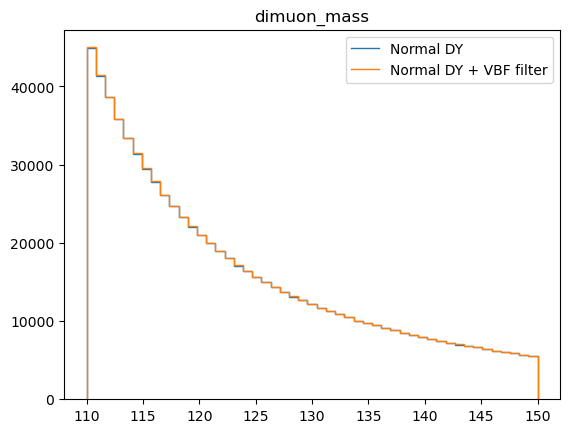

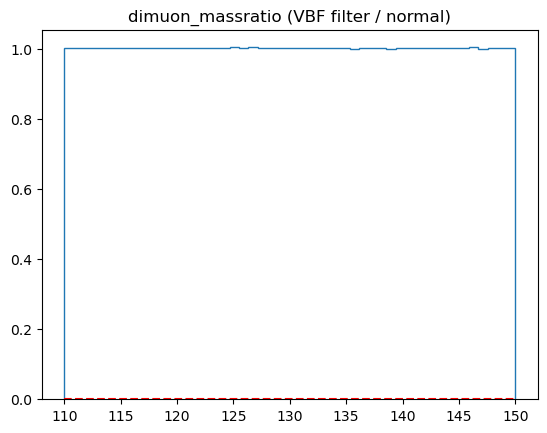

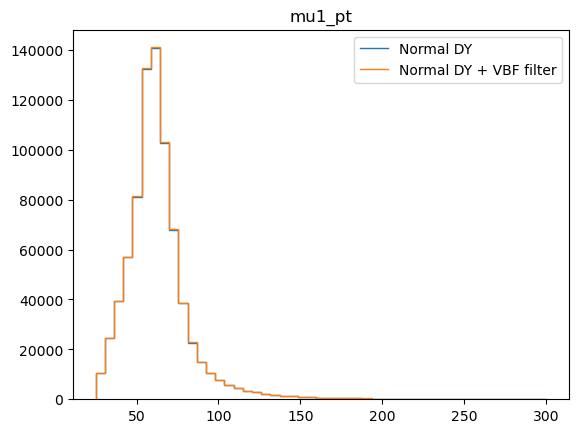

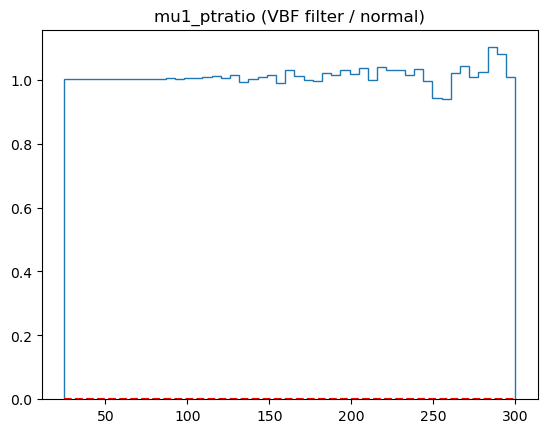

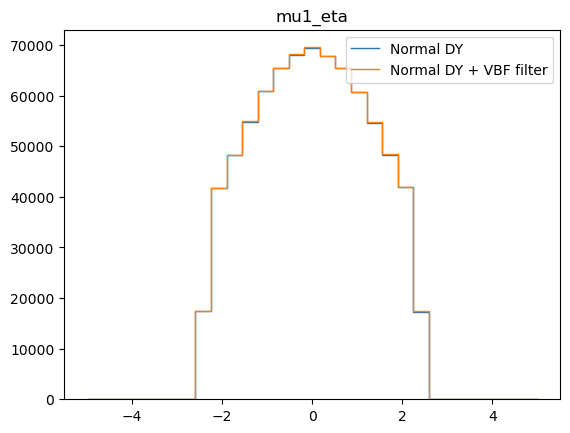

/depot/cms/kernels/coffea2024/lib/python3.10/site-packages/awkward/_nplikes/array_module.py:246: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


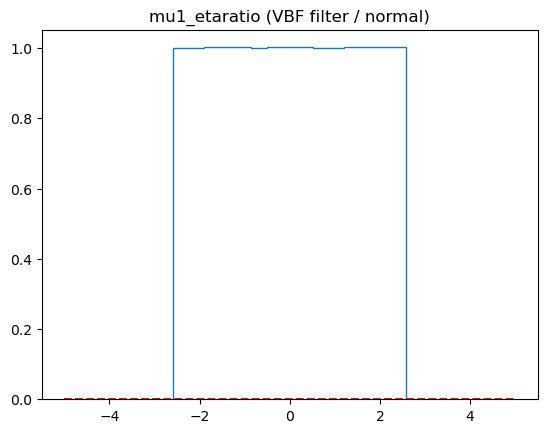

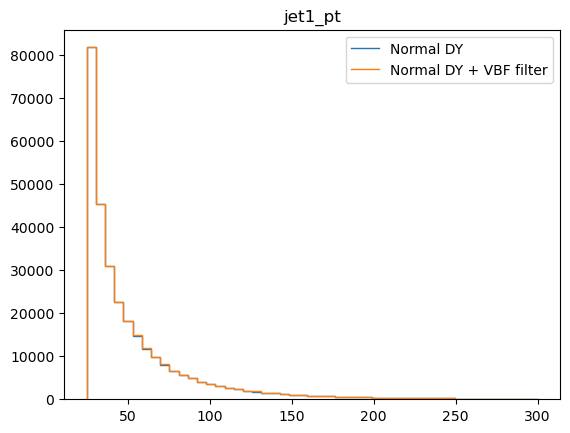

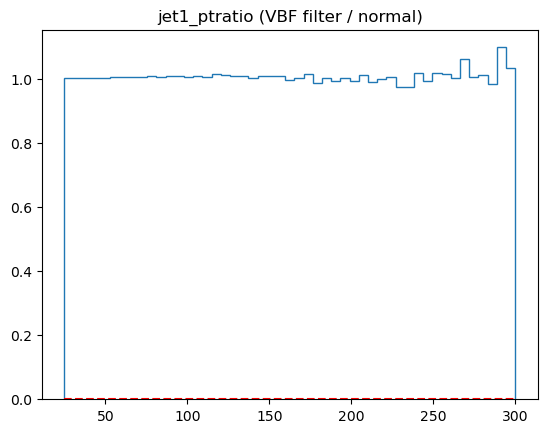

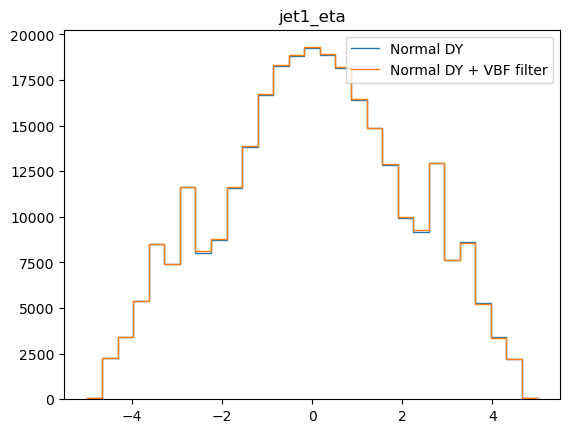

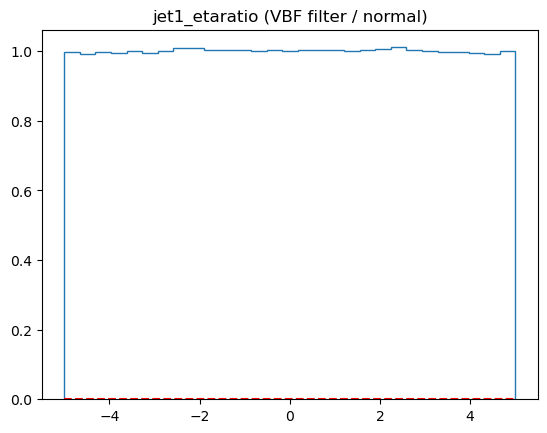

In [8]:

for var in variables:
    kin = var.split("_")[-1]
    binning = np.linspace(*binning_map[kin])

    hist_normal, edges= np.histogram(df_dyIncl[var], bins=binning ,weights=normal_plot_wgt)

    hist_VbfFilter_dyIncl, _= np.histogram(df_dyIncl[var], bins=binning, weights=filter_plot_dyIncl_wgt)
    hist_VbfFilter_dyVbfFilter, _= np.histogram(df_dyVBFfilter[var], bins=binning, weights=filter_plot_dyVBFfilter_wgt)
    hist_VbfFilter = hist_VbfFilter_dyIncl + hist_VbfFilter_dyVbfFilter

    
    plt.stairs(hist_normal, edges, label = "Normal DY")
    plt.stairs(hist_VbfFilter, edges, label = "Normal DY + VBF filter")
    plt.legend(loc="upper right")
    plt.title(var)
    plt.savefig(f"./quick_plots/{var}.pdf")
    plt.show()
    plt.stairs((hist_VbfFilter/hist_normal), edges)
    plt.title(var+"ratio (VBF filter / normal)")
    plt.hlines(0, min(edges), max(edges), colors='red', linestyles="dashed")
    plt.savefig(f"./quick_plots/{var}_ratio.pdf")
    plt.show()


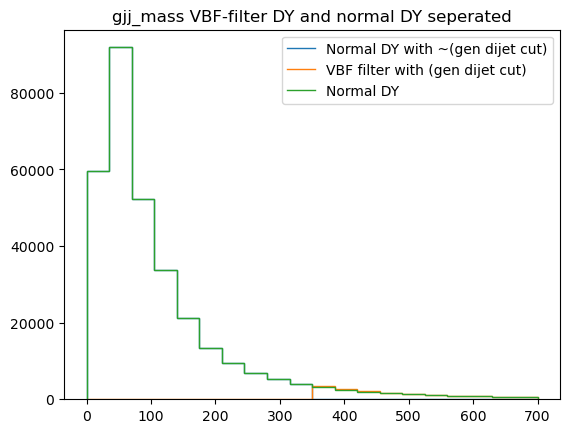

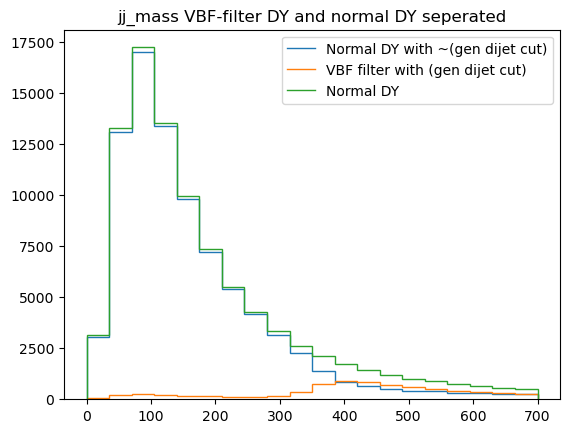

<Figure size 640x480 with 0 Axes>

In [9]:
"""
dijet mass plot of vbf filtered DY vs normal DY 
"""
binning_map = {
    "gjj_mass" : [0, 700, 21],
    # "jj_mass" : [250, 2_000, 21],
    "jj_mass" : [0, 700, 21],
}
for var in ["gjj_mass", "jj_mass"]:
    binning = np.linspace(*binning_map[var])
    hist_VbfFilter_dyIncl, edges = np.histogram(df_dyIncl[var], bins=binning, weights=filter_plot_dyIncl_wgt)
    hist_VbfFilter_dyVbfFilter, _= np.histogram(df_dyVBFfilter[var], bins=binning, weights=filter_plot_dyVBFfilter_wgt)
    hist_dyIncl, _ = np.histogram(df_dyIncl[var], bins=binning, weights=normal_plot_wgt)
    plt.stairs(hist_VbfFilter_dyIncl, edges, label = "Normal DY with ~(gen dijet cut)")
    plt.stairs(hist_VbfFilter_dyVbfFilter, edges, label = "VBF filter with (gen dijet cut)")
    plt.stairs(hist_dyIncl, edges, label = "Normal DY")
    # plt.ylim(0, 1_000)
    plt.legend(loc="upper right")
    plt.title(f"{var} VBF-filter DY and normal DY seperated")
    plt.savefig(f"./quick_plots/{var}_separate.pdf")
    plt.show()
    plt.clf()

err_VbfFilter_dyIncl: [35.5, 33.1, 30.8, 29, 27.1, 25.5, 24.1, 22.7, ..., 0, 0, 0, 0, 0, 0, 0, 0]
err_VbfFilter_dyVbfFilter: [0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 5.31, 5.05, 4.82, 4.61, 4.41, 4.24, 4.05, 3.87]
err_dyIncl: [35.5, 33.1, 30.8, 29, 27.1, 25.5, ..., 15.8, 15.1, 14.4, 13.9, 13.1, 12.6]


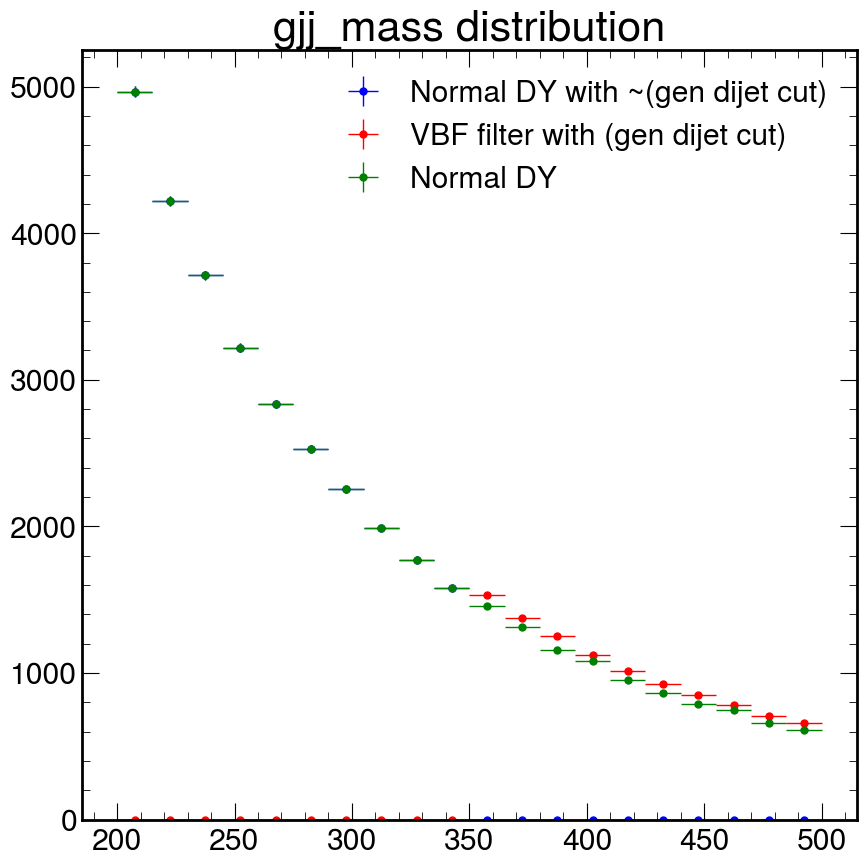

err_VbfFilter_dyIncl: [29, 27, 25.5, 23.9, 22.6, 21.2, 20.2, ..., 8.88, 8.26, 7.93, 7.51, 7.19, 6.9]
err_VbfFilter_dyVbfFilter: [1.29, 1.24, 1.21, 1.17, 1.18, 1.24, ..., 3.25, 3.17, 3.07, 2.97, 2.86, 2.76]
err_dyIncl: [29.2, 27.2, 25.8, 24.2, 22.9, 21.6, 20.7, ..., 14.1, 13.6, 13, 12.4, 12, 11.5]


<Figure size 1000x1000 with 0 Axes>

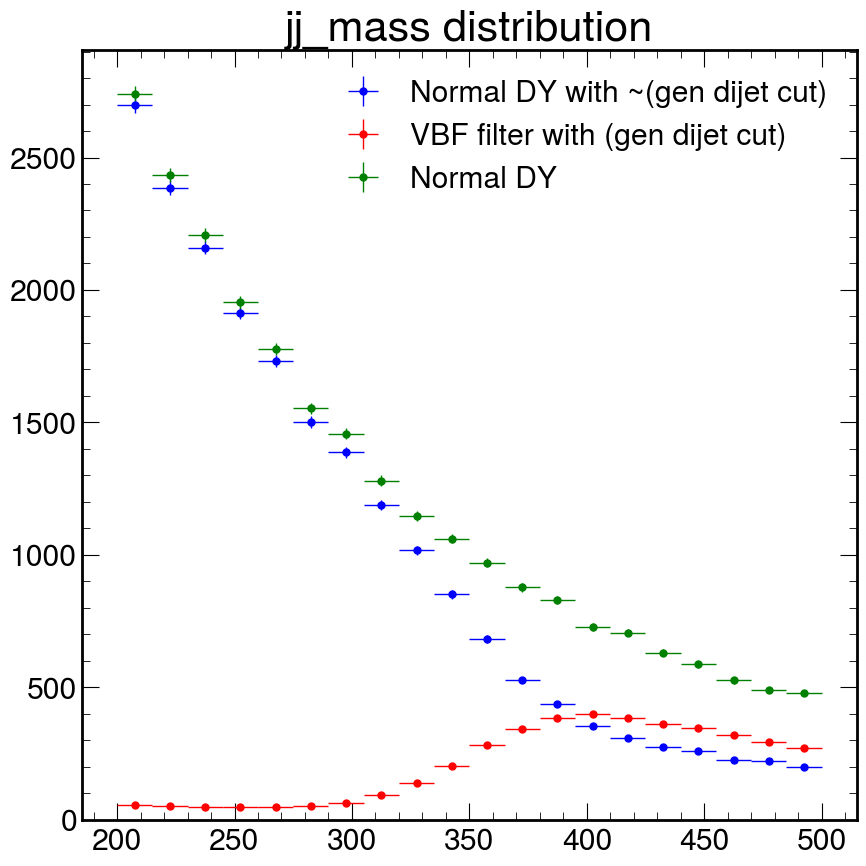

<Figure size 1000x1000 with 0 Axes>

In [22]:
"""
dijet mass plot of vbf filtered DY vs normal DY 
"""
import mplhep as hep
plt.style.use(hep.style.CMS)
binning_map = {
    "gjj_mass" : [200, 500, 21],
    # "jj_mass" : [250, 2_000, 21],
    "jj_mass" : [200, 500, 21],
}


for var in ["gjj_mass", "jj_mass"]:
    fig, ax_main = plt.subplots()
    binning = np.linspace(*binning_map[var])
    hist_VbfFilter_dyIncl, edges = np.histogram(df_dyIncl[var], bins=binning, weights=filter_plot_dyIncl_wgt)
    hist_VbfFilter_dyIncl_w2, _ = np.histogram(df_dyIncl[var], bins=binning, weights=filter_plot_dyIncl_wgt*filter_plot_dyIncl_wgt)
    hist_VbfFilter_dyVbfFilter, _= np.histogram(df_dyVBFfilter[var], bins=binning, weights=filter_plot_dyVBFfilter_wgt)
    hist_VbfFilter_dyVbfFilter_w2, _= np.histogram(df_dyVBFfilter[var], bins=binning, weights=filter_plot_dyVBFfilter_wgt*filter_plot_dyVBFfilter_wgt)
    hist_dyIncl, _ = np.histogram(df_dyIncl[var], bins=binning, weights=normal_plot_wgt)
    hist_dyIncl_w2, _ = np.histogram(df_dyIncl[var], bins=binning, weights=normal_plot_wgt*normal_plot_wgt)

    err_VbfFilter_dyIncl = np.sqrt(hist_VbfFilter_dyIncl_w2)
    print(f"err_VbfFilter_dyIncl: {err_VbfFilter_dyIncl}")
    hep.histplot(hist_VbfFilter_dyIncl, bins=binning, 
         histtype='errorbar', 
        label="Normal DY with ~(gen dijet cut)", 
         xerr=True, 
         yerr=err_VbfFilter_dyIncl,
        # sort='label_r', 
        color = "blue",
        ax=ax_main
    )
    err_VbfFilter_dyVbfFilter = np.sqrt(hist_VbfFilter_dyVbfFilter_w2)
    print(f"err_VbfFilter_dyVbfFilter: {err_VbfFilter_dyVbfFilter}")
    hep.histplot(hist_VbfFilter_dyVbfFilter, bins=binning, 
         histtype='errorbar', 
        label="VBF filter with (gen dijet cut)", 
         xerr=True, 
         yerr=err_VbfFilter_dyVbfFilter,
        # sort='label_r', 
        color = "red",
        ax=ax_main
    )
    err_dyIncl = np.sqrt(hist_dyIncl_w2)
    print(f"err_dyIncl: {err_dyIncl}")
    hep.histplot(hist_dyIncl, bins=binning, 
         histtype='errorbar', 
        label="Normal DY", 
         xerr=True, 
         yerr=err_dyIncl,
        # sort='label_r', 
        color = "green",
        ax=ax_main
    )
    plt.legend(loc="upper right")
    plt.title(f"{var} distribution")
    plt.savefig(f"./quick_plots/{var}_separate_normal.pdf")
    plt.show()
    plt.clf()

In [11]:
print(hist_VbfFilter_dyVbfFilter[10:])
print(hist_dyIncl[10:])
print(hist_dyIncl[10:]/hist_VbfFilter_dyVbfFilter[10:])
print(np.mean(hist_dyIncl[10:]/hist_VbfFilter_dyVbfFilter[10:]))

[1.53e+03, 1.37e+03, 1.25e+03, 1.12e+03, 1.02e+03, 928, 852, 779, 710, 658]
[1.46e+03, 1.32e+03, 1.16e+03, 1.08e+03, 954, 861, 787, 749, 659, 614]
[0.953, 0.957, 0.925, 0.965, 0.939, 0.928, 0.924, 0.961, 0.929, 0.933]
0.9414422852330493


normalization_factor: 0.973796464011618
err_VbfFilter_dyIncl: [35.5, 33.1, 30.8, 29, 27.1, 25.5, 24.1, 22.7, ..., 0, 0, 0, 0, 0, 0, 0, 0]
err_VbfFilter_dyVbfFilter: [0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 5.17, 4.92, 4.69, 4.49, 4.29, 4.12, 3.95, 3.77]
err_dyIncl: [35.5, 33.1, 30.8, 29, 27.1, 25.5, ..., 15.8, 15.1, 14.4, 13.9, 13.1, 12.6]


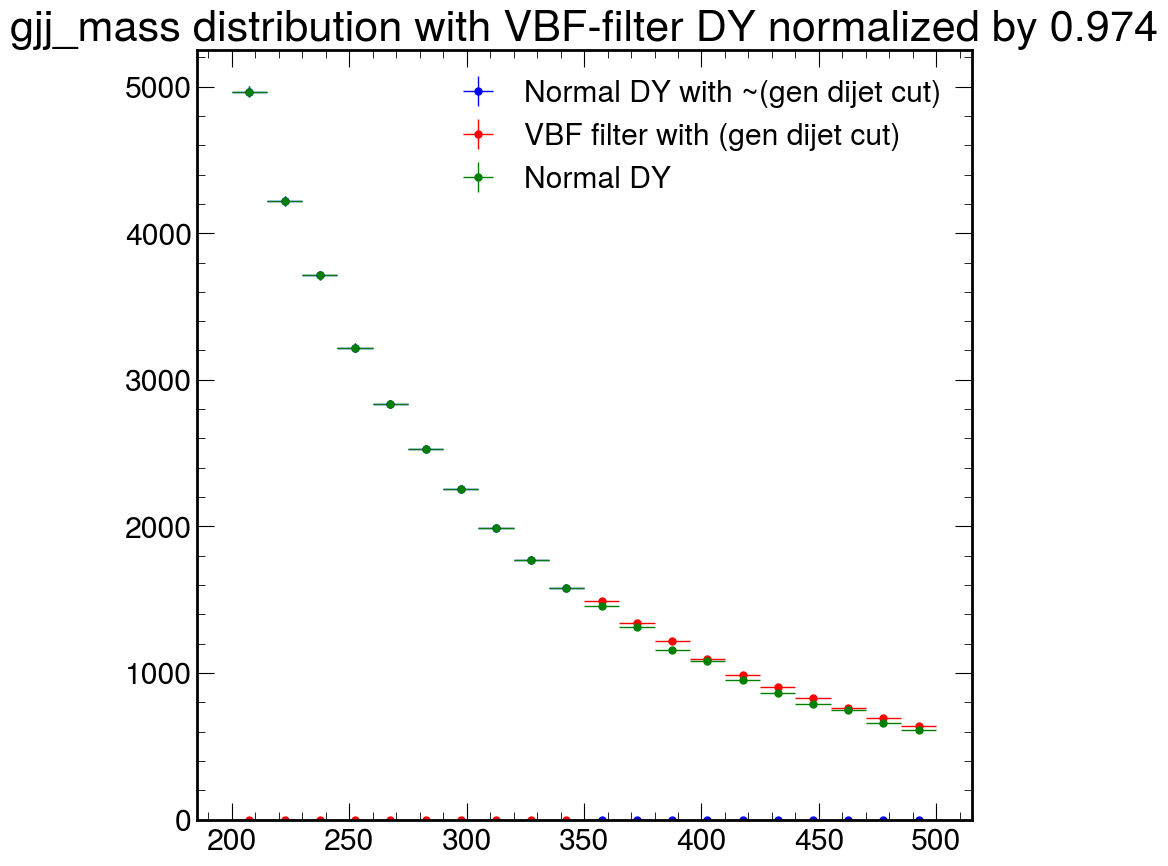

<Figure size 1000x1000 with 0 Axes>

In [15]:
"""
dijet mass plot of vbf filtered DY vs normal DY 
"""
import mplhep as hep
plt.style.use(hep.style.CMS)
binning_map = {
    "gjj_mass" : [200, 500, 21],
    # "jj_mass" : [250, 2_000, 21],
    "jj_mass" : [200, 500, 21],
}

# normalization_factor = 0.5655718250957196
# normalization_factor = 0.6077774950448345
normalization_factor=np.mean(hist_dyIncl[10:]/hist_VbfFilter_dyVbfFilter[10:])
print(f"normalization_factor: {normalization_factor}")

for var in ["gjj_mass"]:
    fig, ax_main = plt.subplots()
    binning = np.linspace(*binning_map[var])
    hist_VbfFilter_dyIncl, edges = np.histogram(df_dyIncl[var], bins=binning, weights=filter_plot_dyIncl_wgt)
    hist_VbfFilter_dyIncl_w2, _ = np.histogram(df_dyIncl[var], bins=binning, weights=filter_plot_dyIncl_wgt*filter_plot_dyIncl_wgt)

    filter_plot_dyVBFfilter_wgt_final = normalization_factor* filter_plot_dyVBFfilter_wgt
    hist_VbfFilter_dyVbfFilter, _= np.histogram(df_dyVBFfilter[var], bins=binning, weights=filter_plot_dyVBFfilter_wgt_final)
    hist_VbfFilter_dyVbfFilter_w2, _= np.histogram(df_dyVBFfilter[var], bins=binning, weights=filter_plot_dyVBFfilter_wgt_final*filter_plot_dyVBFfilter_wgt_final)
    hist_dyIncl, _ = np.histogram(df_dyIncl[var], bins=binning, weights=normal_plot_wgt)
    hist_dyIncl_w2, _ = np.histogram(df_dyIncl[var], bins=binning, weights=normal_plot_wgt*normal_plot_wgt)

    err_VbfFilter_dyIncl = np.sqrt(hist_VbfFilter_dyIncl_w2)
    print(f"err_VbfFilter_dyIncl: {err_VbfFilter_dyIncl}")
    hep.histplot(hist_VbfFilter_dyIncl, bins=binning, 
         histtype='errorbar', 
        label="Normal DY with ~(gen dijet cut)", 
         xerr=True, 
         yerr=err_VbfFilter_dyIncl,
        # sort='label_r', 
        color = "blue",
        ax=ax_main
    )
    err_VbfFilter_dyVbfFilter = np.sqrt(hist_VbfFilter_dyVbfFilter_w2)
    print(f"err_VbfFilter_dyVbfFilter: {err_VbfFilter_dyVbfFilter}")
    hep.histplot(hist_VbfFilter_dyVbfFilter, bins=binning, 
         histtype='errorbar', 
        label="VBF filter with (gen dijet cut)", 
         xerr=True, 
         yerr=err_VbfFilter_dyVbfFilter,
        # sort='label_r', 
        color = "red",
        ax=ax_main
    )
    err_dyIncl = np.sqrt(hist_dyIncl_w2)
    print(f"err_dyIncl: {err_dyIncl}")
    hep.histplot(hist_dyIncl, bins=binning, 
         histtype='errorbar', 
        label="Normal DY", 
         xerr=True, 
         yerr=err_dyIncl,
        # sort='label_r', 
        color = "green",
        ax=ax_main
    )
    plt.legend(loc="upper right")
    plt.title(f"{var} distribution with VBF-filter DY normalized by {normalization_factor:.3g}")
    plt.savefig(f"./quick_plots/{var}_NormFacCheck.pdf")
    plt.show()
    plt.clf()

err_VbfFilter_dyIncl: [5.37, 4.87, 4.83, 4.84, 5.18, 6.32, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0]
err_VbfFilter_dyVbfFilter: [0, 0, 0, 0, 0, 0, 2.38, 2.82, ..., 2.67, 2.52, 2.38, 2.25, 2.13, 2.03, 1.93]
err_dyIncl: [5.37, 4.87, 4.83, 4.84, 5.18, 6.32, ..., 8.68, 8.11, 7.63, 7.16, 6.87, 6.65]


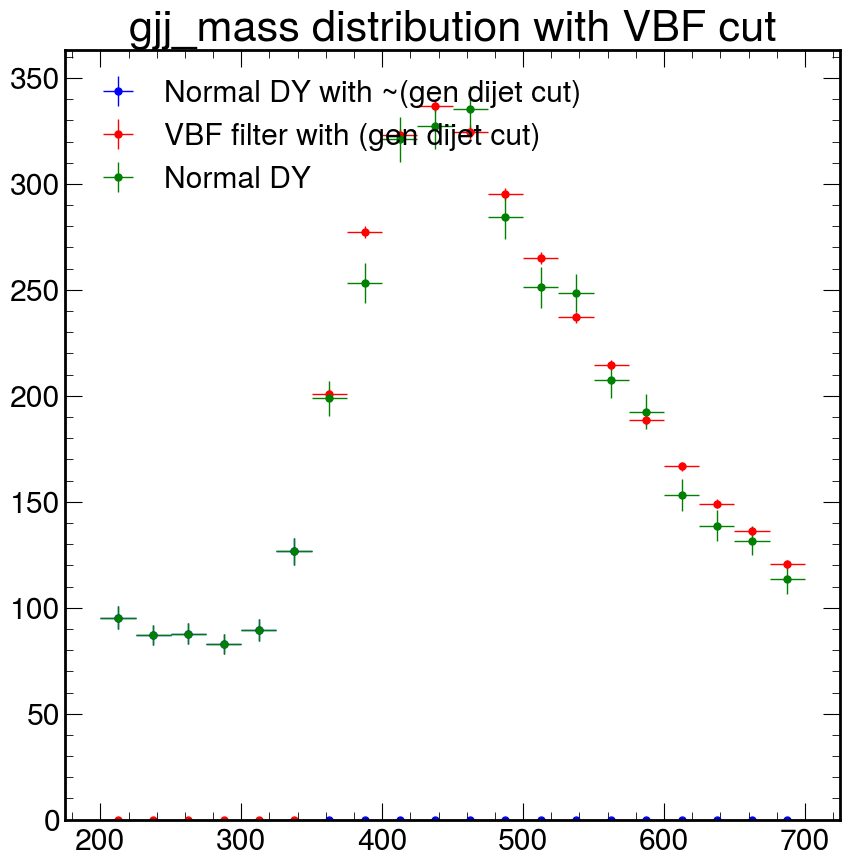

err_VbfFilter_dyIncl: [0, 0, 0, 0, 0, 0, 0, 0, ..., 7.43, 7.14, 6.7, 6.38, 6.15, 5.7, 5.58, 5.23]
err_VbfFilter_dyVbfFilter: [0, 0, 0, 0, 0, 0, 0, 0, ..., 2.91, 2.77, 2.62, 2.48, 2.35, 2.23, 2.11, 2.02]
err_dyIncl: [0, 0, 0, 0, 0, 0, 0, 0, ..., 12.5, 11.7, 11, 10.6, 10.1, 9.48, 9.01, 8.55]


<Figure size 1000x1000 with 0 Axes>

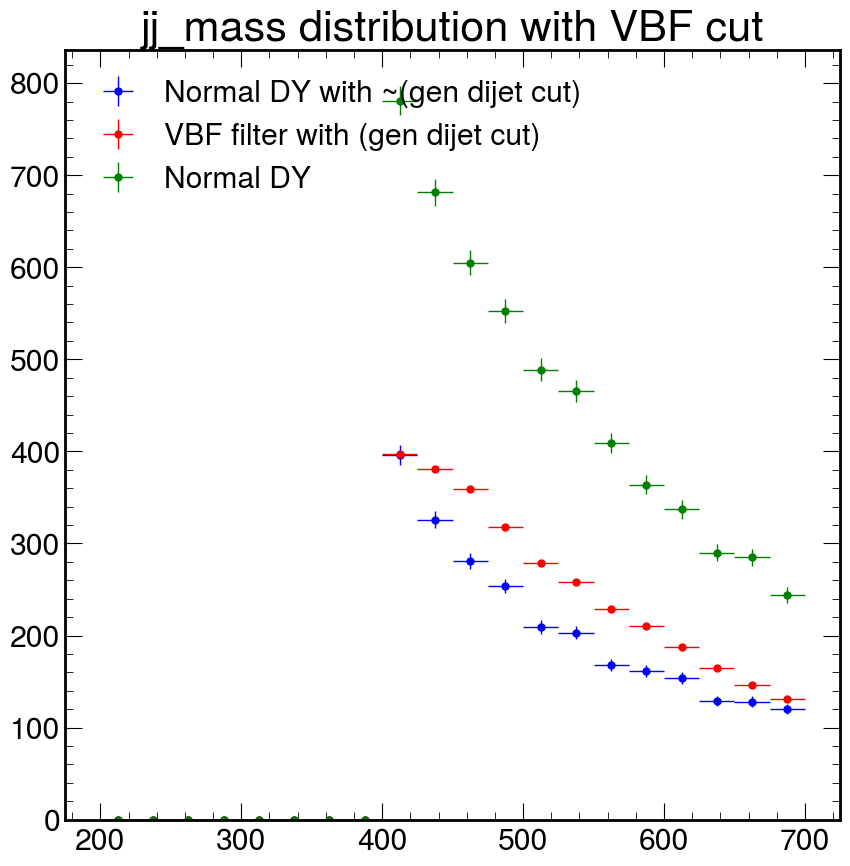

<Figure size 1000x1000 with 0 Axes>

In [21]:
"""
dijet mass plot of vbf filtered DY vs normal DY 
"""
import mplhep as hep
plt.style.use(hep.style.CMS)
binning_map = {
    "gjj_mass" : [200, 700, 21],
    # "jj_mass" : [250, 2_000, 21],
    "jj_mass" : [200, 700, 21],
}


for var in ["gjj_mass","jj_mass"]:
    fig, ax_main = plt.subplots()
    binning = np.linspace(*binning_map[var])
    filter_plot_dyIncl_wgt_final = filter_plot_dyIncl_wgt*vbf_cut_dyIncl
    hist_VbfFilter_dyIncl, edges = np.histogram(df_dyIncl[var], bins=binning, weights=filter_plot_dyIncl_wgt_final)
    hist_VbfFilter_dyIncl_w2, _ = np.histogram(df_dyIncl[var], bins=binning, weights=filter_plot_dyIncl_wgt_final*filter_plot_dyIncl_wgt_final)

    filter_plot_dyVBFfilter_wgt_final = filter_plot_dyVBFfilter_wgt*vbf_cut_dyVBFfilter
    hist_VbfFilter_dyVbfFilter, _= np.histogram(df_dyVBFfilter[var], bins=binning, weights=filter_plot_dyVBFfilter_wgt_final)
    hist_VbfFilter_dyVbfFilter_w2, _= np.histogram(df_dyVBFfilter[var], bins=binning, weights=filter_plot_dyVBFfilter_wgt_final*filter_plot_dyVBFfilter_wgt_final)
    
    normal_plot_wgt_final = normal_plot_wgt*vbf_cut_dyIncl
    hist_dyIncl, _ = np.histogram(df_dyIncl[var], bins=binning, weights=normal_plot_wgt_final)
    hist_dyIncl_w2, _ = np.histogram(df_dyIncl[var], bins=binning, weights=normal_plot_wgt_final*normal_plot_wgt_final)

    err_VbfFilter_dyIncl = np.sqrt(hist_VbfFilter_dyIncl_w2)
    print(f"err_VbfFilter_dyIncl: {err_VbfFilter_dyIncl}")
    hep.histplot(hist_VbfFilter_dyIncl, bins=binning, 
         histtype='errorbar', 
        label="Normal DY with ~(gen dijet cut)", 
         xerr=True, 
         yerr=err_VbfFilter_dyIncl,
        # sort='label_r', 
        color = "blue",
        ax=ax_main
    )
    err_VbfFilter_dyVbfFilter = np.sqrt(hist_VbfFilter_dyVbfFilter_w2)
    print(f"err_VbfFilter_dyVbfFilter: {err_VbfFilter_dyVbfFilter}")
    hep.histplot(hist_VbfFilter_dyVbfFilter, bins=binning, 
         histtype='errorbar', 
        label="VBF filter with (gen dijet cut)", 
         xerr=True, 
         yerr=err_VbfFilter_dyVbfFilter,
        # sort='label_r', 
        color = "red",
        ax=ax_main
    )
    err_dyIncl = np.sqrt(hist_dyIncl_w2)
    print(f"err_dyIncl: {err_dyIncl}")
    hep.histplot(hist_dyIncl, bins=binning, 
         histtype='errorbar', 
        label="Normal DY", 
         xerr=True, 
         yerr=err_dyIncl,
        # sort='label_r', 
        color = "green",
        ax=ax_main
    )
    plt.legend(loc="upper left")
    plt.title(f"{var} distribution with VBF cut")
    plt.savefig(f"./quick_plots/{var}_separate_w_VBFcut.pdf")
    plt.show()
    plt.clf()

In [17]:
print(hist_VbfFilter_dyVbfFilter[10:])
print(hist_dyIncl[10:])
print(hist_dyIncl[10:]/hist_VbfFilter_dyVbfFilter[10:])
print(np.mean(hist_dyIncl[10:]/hist_VbfFilter_dyVbfFilter[10:]))

[324, 295, 265, 237, 215, 188, 167, 149, 136, 120]
[335, 284, 251, 248, 207, 193, 153, 139, 132, 113]
[1.03, 0.962, 0.947, 1.05, 0.967, 1.02, 0.919, 0.931, 0.968, 0.941]
0.973796464011618


normalization_factor: 0.973796464011618
err_VbfFilter_dyIncl: [5.37, 4.87, 4.83, 4.84, 5.18, 6.32, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0]
err_VbfFilter_dyVbfFilter: [0, 0, 0, 0, 0, 0, 2.32, 2.75, ..., 2.6, 2.45, 2.32, 2.19, 2.08, 1.97, 1.88]
err_dyIncl: [5.37, 4.87, 4.83, 4.84, 5.18, 6.32, ..., 8.68, 8.11, 7.63, 7.16, 6.87, 6.65]


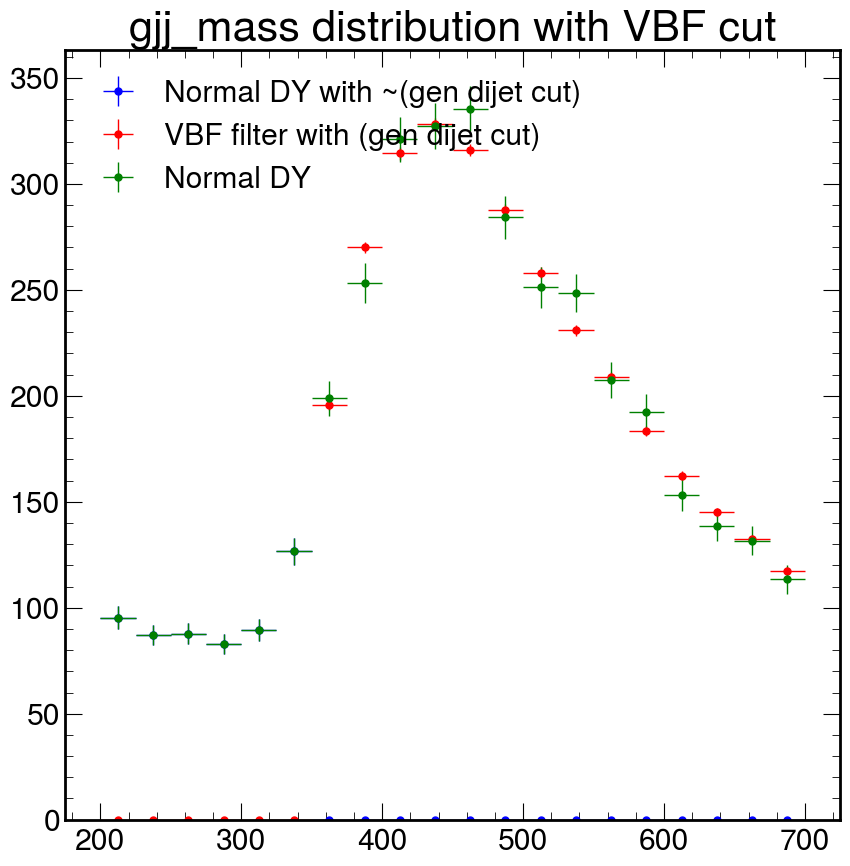

<Figure size 1000x1000 with 0 Axes>

In [18]:
"""
dijet mass plot of vbf filtered DY vs normal DY 
"""
import mplhep as hep
plt.style.use(hep.style.CMS)
binning_map = {
    "gjj_mass" : [200, 700, 21],
    # "jj_mass" : [250, 2_000, 21],
    "jj_mass" : [200, 700, 21],
}

normalization_factor=np.mean(hist_dyIncl[10:]/hist_VbfFilter_dyVbfFilter[10:])
print(f"normalization_factor: {normalization_factor}")

for var in ["gjj_mass"]:
    fig, ax_main = plt.subplots()
    binning = np.linspace(*binning_map[var])
    filter_plot_dyIncl_wgt_final = filter_plot_dyIncl_wgt*vbf_cut_dyIncl
    hist_VbfFilter_dyIncl, edges = np.histogram(df_dyIncl[var], bins=binning, weights=filter_plot_dyIncl_wgt_final)
    hist_VbfFilter_dyIncl_w2, _ = np.histogram(df_dyIncl[var], bins=binning, weights=filter_plot_dyIncl_wgt_final*filter_plot_dyIncl_wgt_final)

    filter_plot_dyVBFfilter_wgt_final = filter_plot_dyVBFfilter_wgt*vbf_cut_dyVBFfilter*normalization_factor
    hist_VbfFilter_dyVbfFilter, _= np.histogram(df_dyVBFfilter[var], bins=binning, weights=filter_plot_dyVBFfilter_wgt_final)
    hist_VbfFilter_dyVbfFilter_w2, _= np.histogram(df_dyVBFfilter[var], bins=binning, weights=filter_plot_dyVBFfilter_wgt_final*filter_plot_dyVBFfilter_wgt_final)
    
    normal_plot_wgt_final = normal_plot_wgt*vbf_cut_dyIncl
    hist_dyIncl, _ = np.histogram(df_dyIncl[var], bins=binning, weights=normal_plot_wgt_final)
    hist_dyIncl_w2, _ = np.histogram(df_dyIncl[var], bins=binning, weights=normal_plot_wgt_final*normal_plot_wgt_final)

    err_VbfFilter_dyIncl = np.sqrt(hist_VbfFilter_dyIncl_w2)
    print(f"err_VbfFilter_dyIncl: {err_VbfFilter_dyIncl}")
    hep.histplot(hist_VbfFilter_dyIncl, bins=binning, 
         histtype='errorbar', 
        label="Normal DY with ~(gen dijet cut)", 
         xerr=True, 
         yerr=err_VbfFilter_dyIncl,
        # sort='label_r', 
        color = "blue",
        ax=ax_main
    )
    err_VbfFilter_dyVbfFilter = np.sqrt(hist_VbfFilter_dyVbfFilter_w2)
    print(f"err_VbfFilter_dyVbfFilter: {err_VbfFilter_dyVbfFilter}")
    hep.histplot(hist_VbfFilter_dyVbfFilter, bins=binning, 
         histtype='errorbar', 
        label="VBF filter with (gen dijet cut)", 
         xerr=True, 
         yerr=err_VbfFilter_dyVbfFilter,
        # sort='label_r', 
        color = "red",
        ax=ax_main
    )
    err_dyIncl = np.sqrt(hist_dyIncl_w2)
    print(f"err_dyIncl: {err_dyIncl}")
    hep.histplot(hist_dyIncl, bins=binning, 
         histtype='errorbar', 
        label="Normal DY", 
         xerr=True, 
         yerr=err_dyIncl,
        # sort='label_r', 
        color = "green",
        ax=ax_main
    )
    plt.legend(loc="upper left")
    plt.title(f"{var} distribution with VBF cut")
    plt.savefig(f"./quick_plots/{var}_separate_w_VBFcut_NormFacCheck.pdf")
    plt.show()
    plt.clf()

In [ ]:
np.linspace(*[200, 700, 21])

In [ ]:
"""
dijet mass plot of vbf filtered DY vs normal DY with no vbf fitlering
"""
binning_map = {
    "gjj_mass" : [0, 700, 21],
    # "jj_mass" : [250, 2_000, 21],
    "jj_mass" : [0, 700, 21],
}


for var in ["gjj_mass", "jj_mass"]:
    binning = np.linspace(*binning_map[var])
    hist_VbfFilter_dyIncl, edges = np.histogram(df_dyIncl[var], bins=binning, weights=weights_dyIncl)
    hist_VbfFilter_dyVbfFilter, _= np.histogram(df_dyVBFfilter[var], bins=binning, weights=weights_dyVBFfilter)
    # hist_dyIncl, _ = np.histogram(df_dyIncl[var], bins=binning, weights=normal_plot_wgt)
    plt.stairs(hist_VbfFilter_dyIncl, edges, label = "Normal DY with ~(gen dijet cut)")
    plt.stairs(hist_VbfFilter_dyVbfFilter, edges, label = "VBF filter with (gen dijet cut)")
    # plt.stairs(hist_dyIncl, edges, label = "Normal DY")
    # plt.ylim(0, 1_000)
    plt.legend(loc="upper right")
    plt.title(f"{var} VBF-filter DY and normal DY seperated")
    # plt.savefig(f"./quick_plots/{var}_separate.pdf")
    plt.show()
    plt.clf()



In [ ]:
"""
dijet mass plot of vbf filtered DY vs normal DY 
"""
binning_map = {
    "gjj_mass" : [0, 700, 21],
    # "jj_mass" : [250, 2_000, 21],
    "jj_mass" : [0, 700, 21],
}


for var in ["gjj_mass"]:
    binning = np.linspace(*binning_map[var])
    hist_VbfFilter_dyIncl, edges = np.histogram(df_dyIncl[var], bins=binning, weights=filter_plot_dyIncl_wgt)
    hist_VbfFilter_dyVbfFilter, _= np.histogram(df_dyVBFfilter[var], bins=binning, weights=filter_plot_dyVBFfilter_wgt)
    hist_dyIncl, _ = np.histogram(df_dyIncl[var], bins=binning, weights=normal_plot_wgt)
    plt.stairs(hist_VbfFilter_dyIncl, edges, label = "Normal DY with ~(gen dijet cut)")
    plt.stairs(hist_VbfFilter_dyVbfFilter, edges, label = "VBF filter with (gen dijet cut)")
    plt.stairs(hist_dyIncl, edges, label = "Normal DY")
    # plt.ylim(0, 1_000)
    plt.legend(loc="upper right")
    plt.title(f"{var} VBF-filter DY and normal DY seperated")
    # plt.savefig(f"./quick_plots/{var}_separate.pdf")
    plt.show()
    plt.clf()

In [ ]:
"""
dijet mass plot of vbf filtered DY vs normal DY 
"""
binning_map = {
    "gjj_mass" : [0, 700, 21],
    # "jj_mass" : [250, 2_000, 21],
    "jj_mass" : [350, 1000, 21],
}


for var in ["jj_mass"]:
    binning = np.linspace(*binning_map[var])
    hist_VbfFilter_dyIncl, edges = np.histogram(df_dyIncl[var], bins=binning, weights=filter_plot_dyIncl_wgt)
    hist_VbfFilter_dyVbfFilter, _= np.histogram(df_dyVBFfilter[var], bins=binning, weights=filter_plot_dyVBFfilter_wgt)
    hist_dyIncl, _ = np.histogram(df_dyIncl[var], bins=binning, weights=normal_plot_wgt)
    plt.stairs((hist_VbfFilter_dyIncl+hist_VbfFilter_dyVbfFilter), edges, label = "Normal DY + VBF filter")
    plt.stairs(hist_dyIncl, edges, label = "Normal DY")
    plt.legend(loc="upper right")
    plt.title(f"{var} (Normal DY + VBF filter) VS (Normal DY ) for (ggH + VBF) cut")
    plt.show()
    plt.clf()
    # plt.savefig(f"./quick_plots/{var}_separate.pdf")
    hist_VbfFilter_dyIncl, edges = np.histogram(df_dyIncl[var], bins=binning, weights=filter_plot_dyIncl_wgt*vbf_cut_dyIncl)
    hist_VbfFilter_dyVbfFilter, _= np.histogram(df_dyVBFfilter[var], bins=binning, weights=filter_plot_dyVBFfilter_wgt*vbf_cut_dyVBFfilter)
    hist_dyIncl, _ = np.histogram(df_dyIncl[var], bins=binning, weights=normal_plot_wgt*vbf_cut_dyIncl)
    plt.stairs((hist_VbfFilter_dyIncl+hist_VbfFilter_dyVbfFilter), edges, label = "Normal DY + VBF filter")
    plt.stairs(hist_dyIncl, edges, label = "Normal DY")
    plt.legend(loc="upper right")
    plt.title(f"{var} (Normal DY + VBF filter) VS (Normal DY ) for VBF cat")
    plt.show()
    hist_VbfFilter_dyIncl, edges = np.histogram(df_dyIncl[var], bins=binning, weights=filter_plot_dyIncl_wgt*(~vbf_cut_dyIncl))
    hist_VbfFilter_dyVbfFilter, _= np.histogram(df_dyVBFfilter[var], bins=binning, weights=filter_plot_dyVBFfilter_wgt*(~vbf_cut_dyVBFfilter))
    hist_dyIncl, _ = np.histogram(df_dyIncl[var], bins=binning, weights=normal_plot_wgt*(~vbf_cut_dyIncl))
    plt.stairs((hist_VbfFilter_dyIncl+hist_VbfFilter_dyVbfFilter), edges, label = "Normal DY + VBF filter")
    plt.stairs(hist_dyIncl, edges, label = "Normal DY")
    plt.legend(loc="upper right")
    plt.title(f"{var} (Normal DY + VBF filter) VS (Normal DY ) for ggH cat")
    plt.show()
    plt.clf()

In [ ]:
"""
dijet mass plot of vbf filtered DY vs normal DY 
"""
binning_map = {
    "gjj_mass" : [350, 700, 21],
    "jj_mass" : [0, 700, 21],
}


for var in ["gjj_mass"]:
    binning = np.linspace(*binning_map[var])
    # hist_VbfFilter_dyIncl, edges = np.histogram(df_dyIncl[var], bins=binning, weights=filter_plot_dyIncl_wgt)
    hist_VbfFilter_dyVbfFilter, edges= np.histogram(df_dyVBFfilter[var], bins=binning, weights=filter_plot_dyVBFfilter_wgt)
    hist_dyIncl, _ = np.histogram(df_dyIncl[var], bins=binning, weights=normal_plot_wgt)
    ratio = hist_VbfFilter_dyVbfFilter/hist_dyIncl
    print(f"ratio: {ratio}")
    print(f"ratio/1.5: {ratio/1.5}")
    plt.stairs(ratio, edges, label = "Ratio of [VBF filter with (gen dijet cut)]/[Normal DY]")
    plt.ylim(0, 4)
    plt.legend(loc="upper right")
    plt.title(f"{var} ratio of (VBF-filter DY)/ (normal DY) ")
    # plt.savefig(f"./quick_plots/{var}_separate.pdf")
    plt.show()
    plt.clf()

In [ ]:
"""
dijet mass plot of vbf filtered DY vs normal DY 
"""
binning_map = {
    "gjj_mass" : [0, 2*700, 21],
    # "jj_mass" : [250, 2_000, 21],
    "jj_mass" : [0, 700, 21],
}

factor = 1.5
for var in ["gjj_mass"]:
    binning = np.linspace(*binning_map[var])
    hist_VbfFilter_dyIncl, edges = np.histogram(df_dyIncl[var], bins=binning, weights=filter_plot_dyIncl_wgt)
    hist_VbfFilter_dyVbfFilter, _= np.histogram(df_dyVBFfilter[var], bins=binning, weights=filter_plot_dyVBFfilter_wgt/factor)
    hist_dyIncl, _ = np.histogram(df_dyIncl[var], bins=binning, weights=normal_plot_wgt)
    plt.stairs(hist_VbfFilter_dyIncl, edges, label = "Normal DY with ~(gen dijet cut)")
    plt.stairs(hist_VbfFilter_dyVbfFilter, edges, label = "VBF filter with (gen dijet cut)")
    plt.stairs(hist_dyIncl, edges, label = "Normal DY")
    plt.ylim(0, 1_000)
    plt.legend(loc="upper right")
    plt.title(f"{var} (VBF-filter DY)/{factor} and normal DY seperated")
    plt.savefig(f"./quick_plots/{var}_separate.pdf")
    plt.show()
    plt.clf()

In [ ]:
70.1*5

In [ ]:
np.linspace(*[0, 2*700, 21])